# Modelagem Física Usando IA: PINN do MRUV

## Visão Geral do Problema

O objetivo é permitir que um algoritmo de Deep Learning (DL) aprenda a prever a posição e velocidade de um instante $t+1$ dadas a posição  e velocidade num instante $t$ através de uma Rede Neural Informada pela Física (PINN), com uma função de perda customizada para ensinar ao modelo a conservação de energia. 

Na Física, o MRUV é o Movimento Retílineo Uniformemente Variado, ele é caracterizado por aceleração constante. Sua equação de posição é expressa por: $$ x_t = x_0 + vt + \frac{at^2}{2}  $$ Portanto, a velocidade é a derivada temporal dessa expressão: $$ \frac{dx}{dt} = v_0 + at $$

Para efeito de aproximação com a realidade, será adicionado ruído gaussiano ($\epsilon$) aos dados, gerando então: $$ x_t = x_0 + vt + \frac{at^2}{2} + \epsilon $$ além de  $$ \frac{dx}{dt} = v_0 + at + \epsilon$$



## Conservação de Energia na Loss

A energia mecânica de um sistema físico é sempre conservada, é dada pela soma da cinética pela potencial: $$ E_m = E_k + E_p $$ respectivamente $ E_k = \frac{1}{2} \frac{dx}{dt} ^2 $ e $ E_p = mgh$. Devido ao fato do objeto não estar em um campo gravitacional, a $ E_p = 0 $, logo a  $ E_m = E_k$.

Para consistentemente aprender com os dados, um modelo de DL precisa aprender os padrões neles; pensando nisso, a arquitetura de PINN permite que o modelo aprenda mais (e melhor) ao ser informado sobre a lei física de conservação de energia.

A função de perda é a métrica que permite entender a comparação global do que é esperado pelas predições e o que é de fato predito pelo modelo. No caso de regressão (como esse), é tipicamente o erro médio quadrático (_mean squared error_): 
$$ loss_{mse} = \frac{1}{N} \sum_{i=1}^{N} (y_{esperado} - y_{predito}) ^2 $$

No caso de uma PINN, a função de perda precisa ser customizada para orientar o modelo sobre a conservação de energia, tomando então a seguinte forma:

$$ loss_{ek} = \frac{1}{N} \sum_{i=1}^{N} (Ek_{esperada} - Ek_{predita}) ^2$$

Combinando linearmente as duas funções de perda para gerar a função de perda geral, temos: $ loss_{pinn} = (1 - \alpha) loss_{mse} + \alpha loss_{ek} $, em que $\alpha$ é o coeficiente da função de perda da PINN, tipicamente $\alpha = 0.5$.

In [1]:
# Importações de libraries importantes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns

In [2]:
# Classe que armazena os dados

class Dados():
    
    def __init__(self, data_points):
        
        
        # Tempo
        self.data_points = data_points
        TEMPO = np.arange(data_points) # s
        
        # Condições iniciais
        POS_0 = -100.0 # m
        VEL_0 = -1.2 #m/s
        ACEL = .1 # m/s^2
        
        
        self.TEMPO = TEMPO
        self.POS_0 = POS_0
        self.VEL_0 = VEL_0
        self.ACEL = ACEL
        
    def dados_tempo(self):
        
        return self.TEMPO
    
    def dados_pos(self):
        
        POS = self.POS_0 + self.TEMPO * self.VEL_0 + (self.ACEL * (self.TEMPO ** 2))/2
        
        POS = POS + np.random.normal(1, 500, size=1001)
        
        return POS
    
    def dados_vel(self):
        
        VEL = self.VEL_0 + self.ACEL * self.TEMPO
        
        VEL = VEL + np.random.normal(1, 1.7, size=1001)
        
        return VEL



In [4]:
# Dados
dados = Dados(1001)

posicao = dados.dados_pos()
tempo = dados.dados_tempo()
velocidade = dados.dados_vel()

In [5]:
df = pd.DataFrame(data={'t': tempo, 'pos': posicao, 'vel': velocidade})
df = df.astype('float64')

In [6]:
df

,t,pos,vel
0,0.0,422.410937,-0.745863
1,1.0,-54.426255,-3.965907
2,2.0,-1189.258807,1.478329
3,3.0,-57.060165,-3.416531
4,4.0,825.510480,-1.135358
...,...,...,...
996,996.0,48479.167172,99.409694
997,997.0,47797.295829,98.354305
998,998.0,48747.237957,97.864459
999,999.0,48823.010276,100.840724


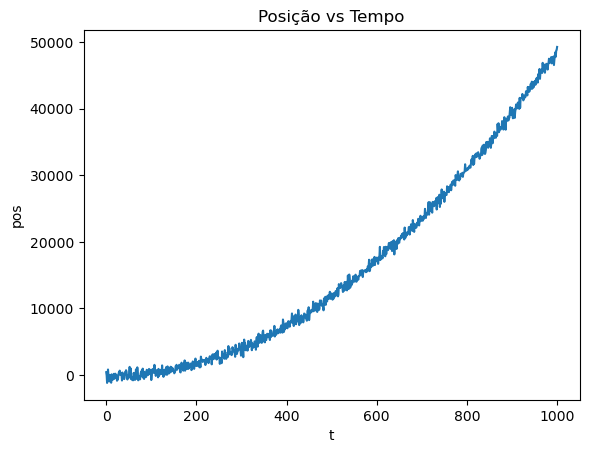

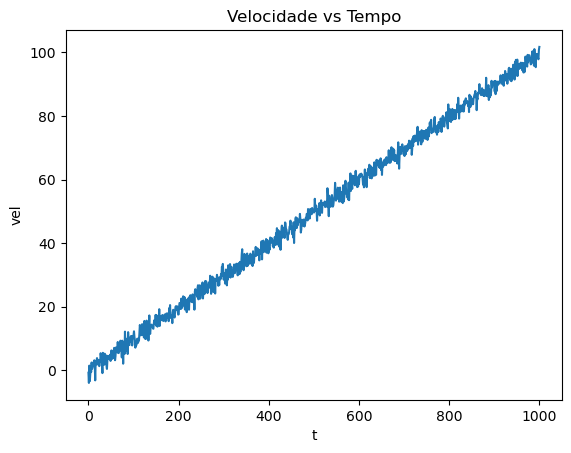

In [7]:
def plotar_dados():
    
    for coluna in ['pos', 'vel']:
        
        sns.lineplot(data=df, x=df['t'], y=df[coluna])
        
        if coluna == 'pos':
            plt.title("Posição vs Tempo")
        else:
            plt.title("Velocidade vs Tempo")
            
        plt.show()

plotar_dados()